In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import metrics
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from plot_sklearn_dendrogram import plot_sklearn_dendrogram # local python file to view dendrogram
from scipy import stats

Our data are separated into two datasets : 
 - The first one will be used for clustering. It gathers information on four variables for each country : 
 The government health expenditures (% of GNI), the Food Deficit (kcal/day/pers), the life expectancy (years) and the natural ressources rents (% of GNI)
 - The second one contains complementary information that will be added to the previous dataset for the classification. Three variables will be added : 
 The surface area (m²), the population and the GNI (US \$)

# Import data

### GNI | Surface | Population dataset

In [3]:
dfgni = pd.read_csv("GNI_Surface_Data.txt",sep="\t",header=0)
dfgni = dfgni.dropna()

In [4]:
dfgni.head()

,Time,Time Code,Country Name,Country Code,Surface,Population,GNI
0,2010,YR2010,Afghanistan,AFG,652860.0,28803167,1.599880e+10
1,2010,YR2010,Bangladesh,BGD,148460.0,152149102,1.246171e+11
2,2010,YR2010,Bhutan,BTN,38394.0,727641,1.497492e+09
3,2010,YR2010,India,IND,3287260.0,1230980691,1.638663e+12
4,2010,YR2010,Maldives,MDV,300.0,364511,2.276923e+09


In [5]:
len(dfgni)

193

After removing all rows with missing values, we have 193 countries left, which is enough to complete our analysis.

### clustering dataset

In [6]:
dfautres = pd.read_csv("autres_Data.txt",sep="\t",header=0)
dfautres = dfautres.dropna()

In [7]:
dfautres.head()

,Time,Time Code,Country Name,Country Code,Gvnt_health_exp,Food Deficit,Life expectancy,Nat_resources_rents
0,2010,YR2010,Afghanistan,AFG,2.255471,158.0,61.226,0.732845
1,2010,YR2010,Bangladesh,BGD,4.071213,119.0,70.198,1.309144
3,2010,YR2010,India,IND,3.169405,115.0,66.625,4.671042
4,2010,YR2010,Maldives,MDV,13.603584,79.0,76.112,0.008966
5,2010,YR2010,Nepal,NPL,4.802811,74.0,67.914,1.470750


In [8]:
len(dfautres)

112

This time there were a few more rows with missing values, but once all removed we still have more than 100 countries. Assuming that we don't remove too much outliers, this number would be enough for our analysis

### classification part 2 dataset

In [9]:
classification2 = pd.read_csv("additional_Data.txt",sep="\t",header=0)
classification2 = classification2.dropna()

In [10]:
classification2.head()

,Time,Time Code,Country Name,Country Code,CO2 emissions,Mortality_diseases,under_five_deaths,Water_use,Suicide_rate,measles_immunization
0,2010,YR2010,Afghanistan,AFG,0.293837,31.7,101383.0,50.046191,5.1,62.0
1,2010,YR2010,Albania,ALB,1.578574,18.6,423.0,88.089492,7.8,99.0
2,2010,YR2010,Algeria,DZA,3.299704,15.4,23676.0,92.388330,3.3,95.0
5,2010,YR2010,Angola,AGO,1.243406,18.1,122844.0,40.057690,5.7,67.0
6,2010,YR2010,Antigua and Barbuda,ATG,5.539568,21.6,16.0,97.088704,0.3,98.0


In [11]:
len(classification2)

182

blabla

# Merge datasets

We now merge the two datasets according to the country code, in order to obtain a full dataset to use for the classification

In [12]:
data = pd.merge(dfgni, dfautres, how='inner', on=['Country Name', 'Country Code'])

In [13]:
data=data.drop(columns=['Time_x', 'Time Code_x', 'Time_y', 'Time Code_y'])

In [14]:
dataComplet = pd.merge(data, classification2, how='inner', on=['Country Name', 'Country Code'])

In [15]:
dataComplet=dataComplet.drop(columns=['Time','Time Code' ])

In [16]:
dataComplet.loc[:,'under_five_deaths']=dataComplet.loc[:,'under_five_deaths']/(dataComplet.loc[:,'Population']//100000)

Since the number of deaths of infants (<5yo) is given directly for each country, we decided to convert it : it will now indicate the number of infant deaths for 100,000 inhabitants (same unit as suicide rate)

In [17]:
# set index with country code
data = data.set_index('Country Code')
dataComplet = dataComplet.set_index('Country Code')

In [18]:
dataComplet.head()

,Country Name,Surface,Population,GNI,Gvnt_health_exp,Food Deficit,Life expectancy,Nat_resources_rents,CO2 emissions,Mortality_diseases,under_five_deaths,Water_use,Suicide_rate,measles_immunization
Country Code,,,,,,,,,,,,,,
AFG,Afghanistan,652860.0,28803167,1.599880e+10,2.255471,158.0,61.226,0.732845,0.293837,31.7,352.024306,50.046191,5.1,62.0
BGD,Bangladesh,148460.0,152149102,1.246171e+11,4.071213,119.0,70.198,1.309144,0.393937,22.2,105.285996,96.502332,6.4,88.0
IND,India,3287260.0,1230980691,1.638663e+12,3.169405,115.0,66.625,4.671042,1.397009,24.2,125.549435,85.262912,16.5,82.0
MDV,Maldives,300.0,364511,2.276923e+09,13.603584,79.0,76.112,0.008966,2.565314,16.7,30.666667,98.191641,3.2,97.0
NPL,Nepal,147180.0,27023137,1.612497e+10,4.802811,74.0,67.914,1.470750,0.187128,23.8,110.233333,85.149949,10.5,86.0


In [19]:
len(dataComplet)

111

# Boxplots

We will now use a normalisation of our data column by column, so we can visualize and detect outliers

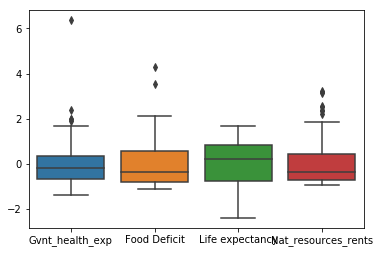

In [20]:
# set index with country code
dfautresn = dfautres
dfautresn = dfautresn.set_index('Country Code')
# boxplot of the clustering data
dfautresn = dfautresn.iloc[:,3:]
Z_scored_dfautres = (dfautresn-dfautresn.mean())/dfautresn.std()
sns.boxplot(data=Z_scored_dfautres)

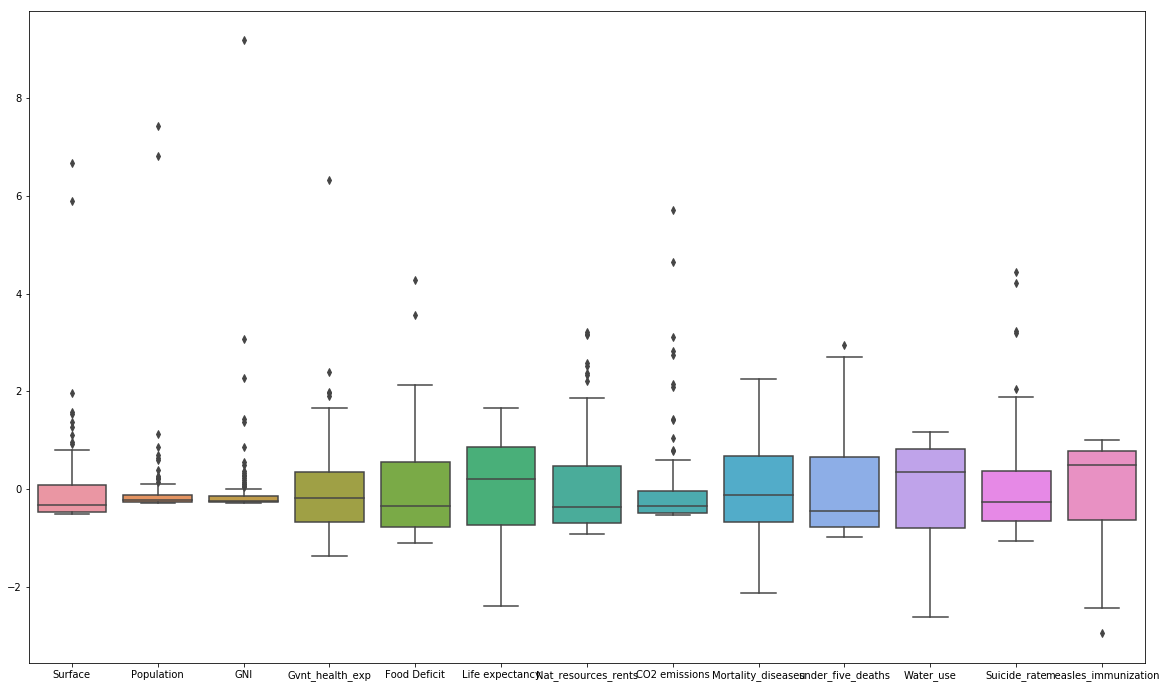

In [21]:
# boxplot with the whole dataset (classification)
plt.figure(figsize=(20,12))
datan = dataComplet.iloc[:,1:]
Z_scored_df = (datan-datan.mean())/datan.std()
sns.boxplot(data=Z_scored_df)

# Outliers detection

As we could previously see, some values seems to be out of range, and might have an influence on our future classification and clusters. We defined a threshold, so that all values above it should be considered as an outlier and removed from the dataset

## dfautres

In [22]:
dfautresn.mean(axis=0)

Gvnt_health_exp          8.378800
Food Deficit           112.348214
Life expectancy         66.760248
Nat_resources_rents     10.867296
dtype: float64

In [23]:
threshold = 2.5
mask = np.abs(dfautresn) > dfautresn.mean()+threshold*dfautresn.std()
outliers = dfautresn[mask.any(axis=1)]

In [24]:
mask.any()

Gvnt_health_exp         True
Food Deficit            True
Life expectancy        False
Nat_resources_rents     True
dtype: bool

In [25]:
mask.loc[sorted(list(set(outliers.index)))]

,Gvnt_health_exp,Food Deficit,Life expectancy,Nat_resources_rents
Country Code,,,,
BLZ,True,False,False,False
COG,False,False,False,True
HTI,False,True,False,False
IRQ,False,False,False,True
KWT,False,False,False,True
MRT,False,False,False,True
SAU,False,False,False,True
ZMB,False,True,False,False


The previous countries are considered as outliers, according to our threshold, but different variables are impacted. Since we would like to keep the oil-producing countries on our analysis, we decided to ignore outliers that are only related to this variable. As to the 3 remaining, we decided to remove them, so our final dataset contains 109 countries.

In [26]:
maskbis=mask.iloc[:,:3]
outliersbis = dfautresn[maskbis.any(axis=1)]

In [27]:
dfautrestri = dfautresn.loc[sorted(list(set(dfautresn.index).difference(set(outliersbis.index))))]

In [28]:
len(dfautrestri)

109

## data

We repete the same procedure on the dataset used for classification

In [29]:
datan.mean(axis=0)

Surface                 6.831314e+05
Population              4.859118e+07
GNI                     1.777908e+11
Gvnt_health_exp         8.391488e+00
Food Deficit            1.116667e+02
Life expectancy         6.681770e+01
Nat_resources_rents     1.095765e+01
CO2 emissions           3.166801e+00
Mortality_diseases      2.142883e+01
under_five_deaths       1.708307e+02
Water_use               7.886848e+01
Suicide_rate            8.101802e+00
measles_immunization    8.554054e+01
dtype: float64

In [30]:
threshold = 2.5
mask2 = np.abs(datan) > datan.mean()+threshold*datan.std()
outliers2 = datan[mask2.any(axis=1)]

In [31]:
mask2.any()

Surface                  True
Population               True
GNI                      True
Gvnt_health_exp          True
Food Deficit             True
Life expectancy         False
Nat_resources_rents      True
CO2 emissions            True
Mortality_diseases      False
under_five_deaths        True
Water_use               False
Suicide_rate             True
measles_immunization    False
dtype: bool

As we previously did, we ignore the outliers related to natural ressources rent

In [32]:
mask2bis=mask2.iloc[:,:6]
outliers2bis = datan[mask2bis.any(axis=1)]
outliers2bis

,Surface,Population,GNI,Gvnt_health_exp,Food Deficit,Life expectancy,Nat_resources_rents,CO2 emissions,Mortality_diseases,under_five_deaths,Water_use,Suicide_rate,measles_immunization
Country Code,,,,,,,,,,,,,
IND,3287260.0,1230980691,1.638663e+12,3.169405,115.0,66.625,4.671042,1.397009,24.2,125.549435,85.262912,16.5,82.0
CHN,9562911.0,1337705000,6.074549e+12,9.447319,108.0,75.236,6.249178,6.560520,18.1,20.103386,90.849655,10.9,99.0
ZMB,752610.0,13850033,1.890254e+10,3.313305,455.0,56.588,21.387444,0.194337,19.9,324.949275,57.107193,6.3,96.0
BLZ,22970.0,321608,1.239593e+09,41.644164,36.0,69.676,4.992062,1.676106,23.2,47.666667,93.918681,4.9,98.0
BRA,8515770.0,196796269,2.144024e+12,8.392290,17.0,73.838,4.452136,2.132938,19.0,29.126080,96.258078,5.7,99.0
HTI,27750.0,9999617,6.644822e+09,2.545283,524.0,61.296,1.192176,0.212694,22.3,589.121212,62.108173,10.2,64.0


We decided to remove both Haïti and Zambia, because they appear as outliers for our Food Deficit indicator, which is already given in kilocalories per person per day. As for the others outliers, we decided to calculate Density instead of keeping Surface and Population, and divided GNI by the population, so that it is expressed as a ratio of the total population.

In [33]:
datanbis=datan.copy(deep=True)
Density=datanbis.iloc[:,1]/datanbis.iloc[:,0]
datanbis.iloc[:,2]=datanbis.iloc[:,2]/datanbis.iloc[:,1]
datanbis=datanbis.drop(columns="Population")

In [34]:
datanbis.iloc[:,0]=Density
datanbis=datanbis.rename({"Surface":"Density"}, axis='columns')
len(datanbis)

111

In [35]:
threshold = 2.5
mask3 = np.abs(datanbis) > datanbis.mean()+threshold*datanbis.std()
outliers3 = datanbis[mask3.any(axis=1)]
# we keep outliers not related to nat. ressources
mask3=mask3.iloc[:,:5]
outliers3 = datanbis[mask3.any(axis=1)]

In [36]:
mask3.loc[sorted(list(set(outliers3.index)))]

,Density,GNI,Gvnt_health_exp,Food Deficit,Life expectancy
Country Code,,,,,
ARE,False,True,False,False,False
BGD,True,False,False,False,False
BLZ,False,False,True,False,False
BRB,True,False,False,False,False
BRN,False,True,False,False,False
HTI,False,False,False,True,False
KWT,False,True,False,False,False
MDV,True,False,False,False,False
MUS,True,False,False,False,False


As there are even more outliers with transformed data, we decided to keep the former dataframe and remove the outliers previously identified

In [37]:
outliers2bis

,Surface,Population,GNI,Gvnt_health_exp,Food Deficit,Life expectancy,Nat_resources_rents,CO2 emissions,Mortality_diseases,under_five_deaths,Water_use,Suicide_rate,measles_immunization
Country Code,,,,,,,,,,,,,
IND,3287260.0,1230980691,1.638663e+12,3.169405,115.0,66.625,4.671042,1.397009,24.2,125.549435,85.262912,16.5,82.0
CHN,9562911.0,1337705000,6.074549e+12,9.447319,108.0,75.236,6.249178,6.560520,18.1,20.103386,90.849655,10.9,99.0
ZMB,752610.0,13850033,1.890254e+10,3.313305,455.0,56.588,21.387444,0.194337,19.9,324.949275,57.107193,6.3,96.0
BLZ,22970.0,321608,1.239593e+09,41.644164,36.0,69.676,4.992062,1.676106,23.2,47.666667,93.918681,4.9,98.0
BRA,8515770.0,196796269,2.144024e+12,8.392290,17.0,73.838,4.452136,2.132938,19.0,29.126080,96.258078,5.7,99.0
HTI,27750.0,9999617,6.644822e+09,2.545283,524.0,61.296,1.192176,0.212694,22.3,589.121212,62.108173,10.2,64.0


In [38]:
datatri = datan.loc[sorted(list(set(datan.index).difference(set(outliers2bis.index))))]

In [39]:
len(datatri)

105

# Correlation



## dfautrestri

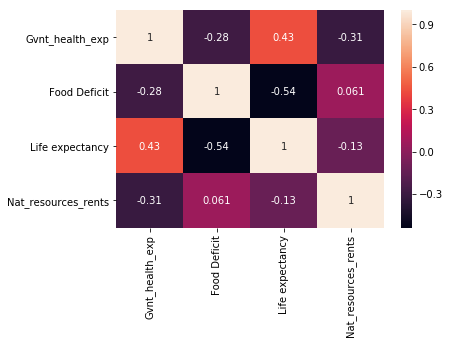

In [40]:
sns.heatmap(dfautrestri.corr(),annot=True)

We can see that the Life expectancy values are correlated both to the Food deficit values and to the Government health expenditure values. From that first test, we can say that countries with a lower food deficit and with higher health expenditures tend to have a higher life expectancy.

## datatri

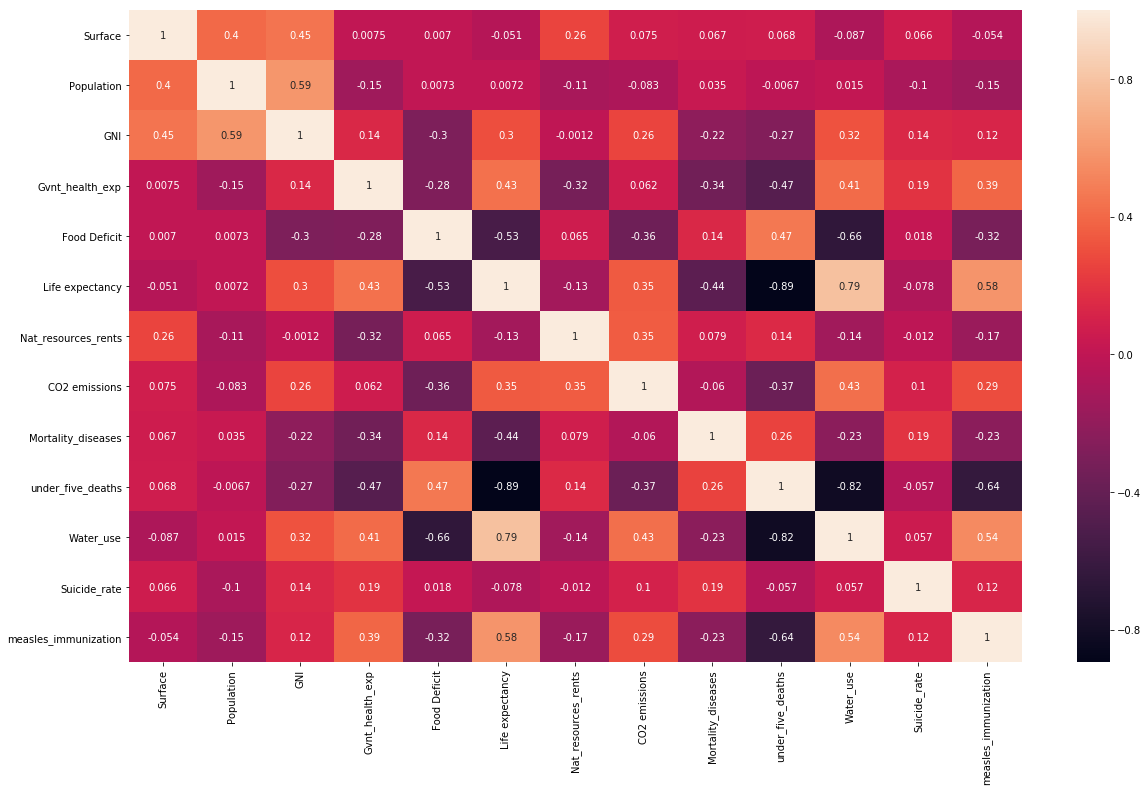

In [41]:
plt.figure(figsize=(20,12))
sns.heatmap(datatri.corr(),annot=True)

# Normalize data 

## dfautrestri

In [42]:
Z_dfautrestri = (dfautrestri - dfautrestri.mean())/dfautrestri.std()

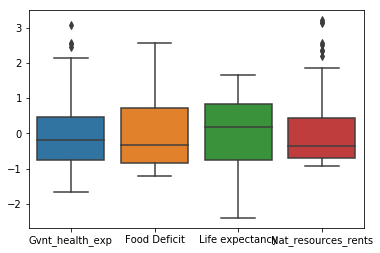

In [43]:
# boxplot of the clustering data after removing the outliers
dfautresn = dfautresn.iloc[:,3:]
Z_scored_dfautres = (dfautresn-dfautresn.mean())/dfautresn.std()
sns.boxplot(data=Z_dfautrestri)

## datatri

In [44]:
Z_datatri = (datatri - datatri.mean())/datatri.std()

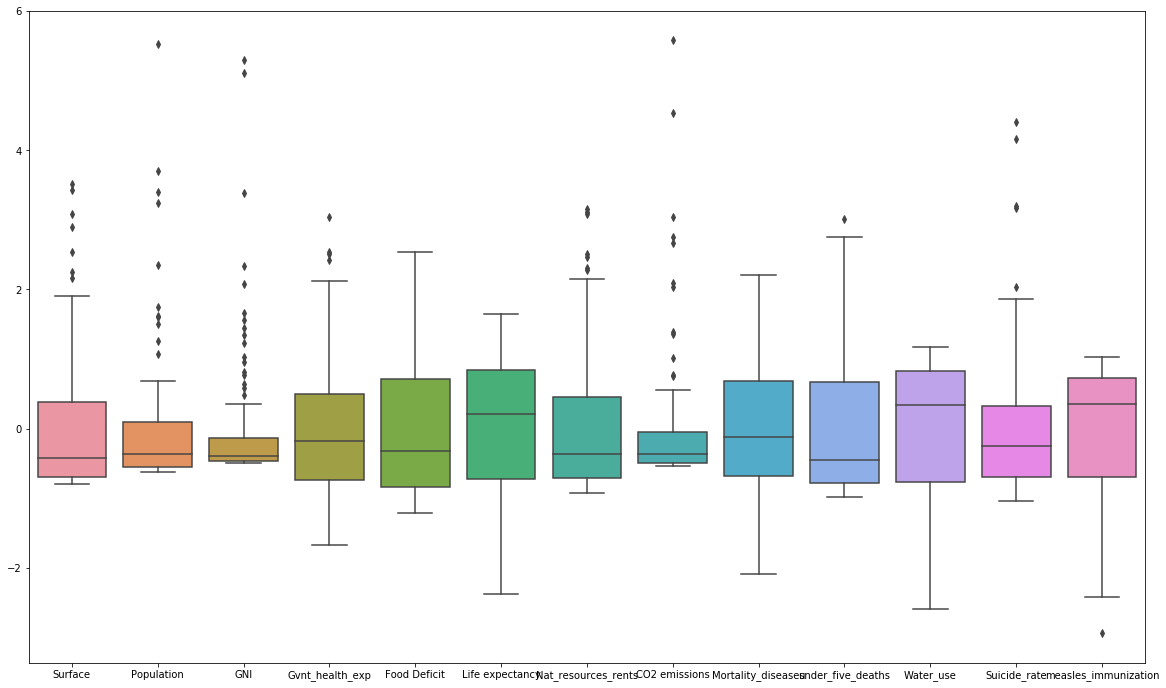

In [45]:
# boxplot with the whole dataset (classification) after removing the outliers
plt.figure(figsize=(20,12))
datan = data.iloc[:,1:]
Z_scored_df = (datan-datan.mean())/datan.std()
sns.boxplot(data=Z_datatri)

# Clustering (dfautrestri)

## Hierarchical clustering

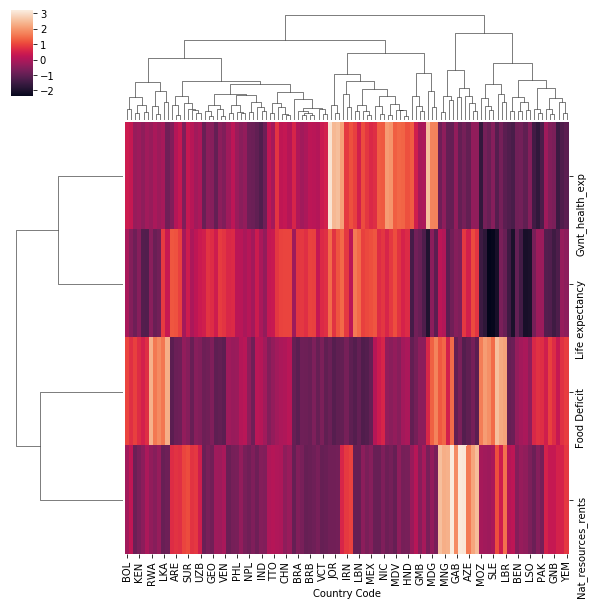

In [46]:
sns.clustermap(Z_dfautrestri.T,method='complete')

## agglomerative clustering

In [47]:
agc = AgglomerativeClustering(n_clusters=4, affinity="euclidean", linkage="average")
agc.fit(Z_dfautrestri)
        
dffdv = Z_dfautrestri.values # get the data matrix of values (dataframe feature data values)
clustersAgglo = (agc.labels_+1)*100 #cluster labels for each point
AggloLabels = map(str,sorted(set(clustersAgglo.tolist())))
AggloLabels

['100', '200', '300', '400']

In [48]:
Z_dfautrestri2=Z_dfautrestri.copy()

In [49]:
Z_dfautrestri2=Z_dfautrestri2.assign(cluster=clustersAgglo)

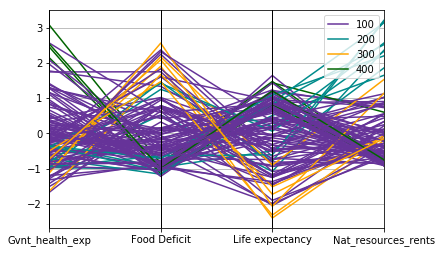

In [50]:
# Represent the clustered data using the parallel coordinates method
from pandas.plotting import parallel_coordinates
parallel_coordinates(Z_dfautrestri2,'cluster', color=('rebeccapurple', 'darkcyan', 'orange', 'darkgreen'))
plt.show()

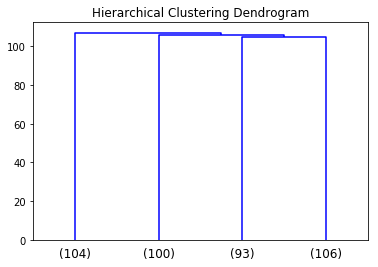

In [51]:
plt.title('Hierarchical Clustering Dendrogram')
plot_sklearn_dendrogram(agc, labels=agc.labels_, truncate_mode='lastp', p=4) #cf plot_sklearn_dendrogram.py
plt.show()

In [52]:
# silhouette score
metrics.silhouette_score(dffdv, clustersAgglo, metric='euclidean', sample_size=None) # sample_size=None for no sampling 

0.17086809792513927

In [53]:
# to get feature importance
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100)
rf.fit(Z_dfautrestri, clustersAgglo)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [54]:
# feature importance
rf.feature_importances_

array([0.22005935, 0.14176762, 0.16972591, 0.46844711])

We can see that "Natural Ressources rents" is the most important feature

## Kmeans

In [55]:
## test du nombre de cluster:
SSE = [] #stockage des SSE pour chaque nombre de cluster
silh = [] #stockage des coeff silhouettes pour chaque nombre de cluster
for i in range(2,10):
    kmeans = KMeans(i)
    kmeans = kmeans.fit(Z_dfautrestri)
    Z_dfautrestri["cluster"] = kmeans.predict(Z_dfautrestri)
    SSE.append(kmeans.inertia_)
    silh.append(metrics.silhouette_score(Z_dfautrestri, Z_dfautrestri["cluster"], metric='euclidean', sample_size=None))

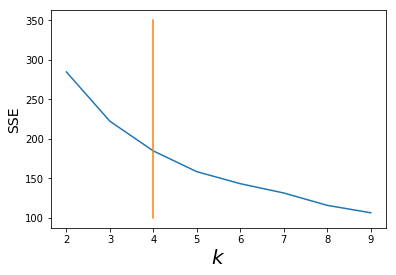

In [56]:
## graphe de la SSE:
plt.plot(range(2,10),SSE)
plt.plot([4,4],[100,350])
plt.xlabel("$k$",fontsize=20)
plt.ylabel("SSE",fontsize=14)

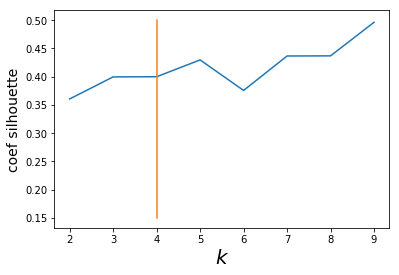

In [57]:
## coeff silhouette:
plt.plot(range(2,10),silh)
plt.plot([4,4],[0.15,0.5])
plt.xlabel("$k$",fontsize=20)
plt.ylabel("coef silhouette",fontsize=14)

In [58]:
from sklearn.cluster import KMeans
kmeans = KMeans(4)
kmeans = kmeans.fit(Z_dfautrestri)
Z_dfautrestri["cluster"] = kmeans.predict(Z_dfautrestri)

In [59]:
metrics.silhouette_score(Z_dfautrestri, Z_dfautrestri["cluster"], metric='euclidean', sample_size=None)

0.29813842347680974

In [60]:
sse = kmeans.inertia_
print "sse =", sse

sse = 315.1859508401693


In [61]:
KLabels = map(str,sorted(set(kmeans.predict(Z_dfautrestri).tolist())))
KLabels

['0', '1', '3']

### Stability

In [62]:
silhouette_coef = []
sse = []
k = 4
n_init=1
for i in range(100):
    km = KMeans(n_clusters=k, n_init=n_init, random_state=i) # create a KMeans object
    km.fit(Z_dfautrestri)
    labels = km.predict(Z_dfautrestri)
    sse.append(km.inertia_)
    silhouette_coef.append(metrics.silhouette_score(Z_dfautrestri, labels, metric='euclidean', sample_size=None))

(array([64., 20.,  8.,  2.,  1.,  0.,  2.,  1.,  1.,  1.]),
 array([228.09237581, 232.15320993, 236.21404406, 240.27487818,
        244.3357123 , 248.39654643, 252.45738055, 256.51821468,
        260.5790488 , 264.63988293, 268.70071705]),
 <a list of 10 Patch objects>)

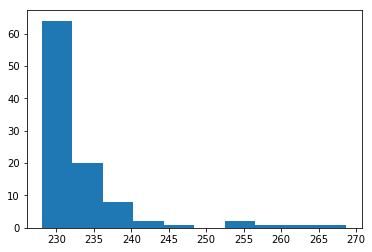

In [63]:
plt.hist(sse)

(array([ 1.,  0.,  2.,  0.,  2.,  7., 20., 29., 15., 24.]),
 array([0.21077451, 0.22515623, 0.23953794, 0.25391966, 0.26830138,
        0.2826831 , 0.29706482, 0.31144653, 0.32582825, 0.34020997,
        0.35459169]),
 <a list of 10 Patch objects>)

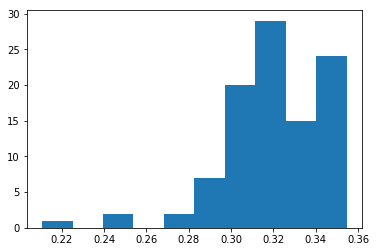

In [64]:
plt.hist(silhouette_coef)

In [65]:
def compute_stability(k,df,iterations=100):
    silhouette_coef = []
    for i in range(iterations):
        km = KMeans(n_clusters=k, n_init=1, random_state=i) # create a KMeans object
        km.fit(df)
        labels = km.predict(df)
        silhouette_coef.append(metrics.silhouette_score(df, labels, metric='euclidean', sample_size=None))
    silhouette_coef = np.asarray(silhouette_coef)
    return(silhouette_coef.std())

In [66]:
stability = []
Ks = range(2,30)
for k in Ks:
    stability.append(compute_stability(k,Z_dfautrestri))

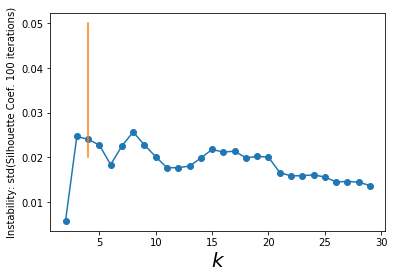

In [67]:
plt.plot(Ks,stability,"o-")
plt.plot([4,4],[0.02,0.050])
plt.xlabel("$k$",fontsize=20)
plt.ylabel("Instability: std(Silhouette Coef. 100 iterations)")

###### ==> we'll keep 4 clusters

### Parallel coordinates method to represent the clustered data

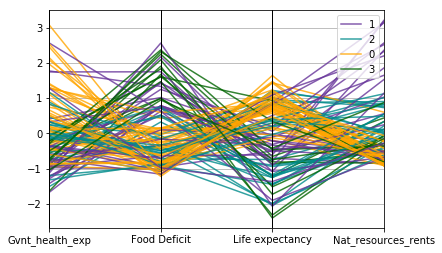

In [68]:
# Represent the clustered data using the parallel coordinates method
from pandas.plotting import parallel_coordinates
parallel_coordinates(Z_dfautrestri,'cluster', color=('rebeccapurple', 'darkcyan', 'orange', 'darkgreen'),alpha=0.8)
plt.show()

### Use a decision Tree to Describe the Clusters

In [69]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix
import graphviz

In [70]:
dt = DecisionTreeClassifier(max_depth=3,criterion="entropy")
prediction_features = [c for c in Z_dfautrestri.columns if c != "cluster"]
dt = dt.fit(Z_dfautrestri[prediction_features],Z_dfautrestri["cluster"])

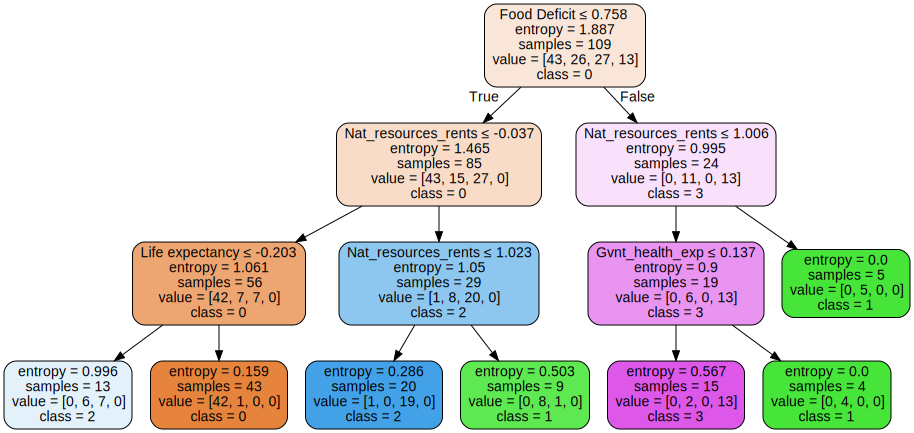

In [71]:
dot_data = export_graphviz(dt, out_file=None, 
                         feature_names=prediction_features,  
                         class_names=["0","1","2","3"], # needs to be lexicographically sorted
                         filled=True, rounded=True,  
                         special_characters=True) 
graph = graphviz.Source(dot_data)
graph

We can see how the different classes are characterized by:
- class 0 : the government health expenditure is low with high natural resources rents
- class 1 : the food deficit is extremely small with a high government health expenditure
- class 2 : the government health expenditure is low with a high food deficit
- class 3 : the government health expenditure, life expectancy and natural resources rents are low

## DBSCAN

In [72]:
dbscan = DBSCAN(eps=0.9, min_samples=5)
dbscan.fit(Z_dfautrestri)

DBSCAN(algorithm='auto', eps=0.9, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=5, n_jobs=1, p=None)

In [73]:
values = Z_dfautrestri.values 
clustersDBS = dbscan.labels_
clustersDBS=(clustersDBS+2)*10
Z_dfautrestri3=Z_dfautrestri.copy()
Z_dfautrestri3=Z_dfautrestri3.assign(cluster=clustersDBS)

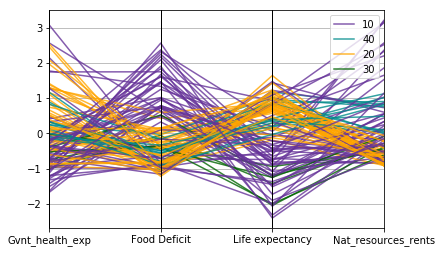

In [74]:
# Represent the clustered data using the parallel coordinates method
from pandas.plotting import parallel_coordinates
parallel_coordinates(Z_dfautrestri3,'cluster', color=('rebeccapurple', 'darkcyan', 'orange', 'darkgreen','black'),alpha=0.8)
plt.show()

In [76]:
metrics.silhouette_score(values, clustersDBS, metric='euclidean', sample_size=None) # sample_size=None for no sampling 

0.15063353464514462

In [77]:
DBSCANLabels = map(str,sorted(set(clustersDBS.tolist())))
DBSCANLabels

['10', '20', '30', '40']

## Comparaison des différents clustering

### Confusion matrix

#### Kmeans vs DBscan

In [78]:
allLabels = KLabels + DBSCANLabels
allLabels

['0', '1', '3', '10', '20', '30', '40']

In [79]:
cm1 = metrics.confusion_matrix(Z_dfautrestri["cluster"].astype(str), clustersDBS.astype(str),labels=allLabels)
cm1.shape

(7, 7)

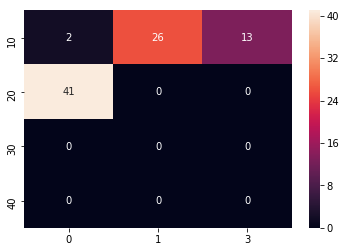

In [80]:
cmdf1 = pd.DataFrame(data=cm1, copy=True, index=allLabels, columns=allLabels).loc[KLabels, DBSCANLabels]
cmdf1 = cmdf1.transpose()
sns.heatmap(cmdf1, annot=True)

#### Kmeans vs Agglomerative clusterring

In [81]:
allLabels2 = KLabels + AggloLabels
allLabels2

['0', '1', '3', '100', '200', '300', '400']

In [82]:
cm2 = metrics.confusion_matrix(Z_dfautrestri["cluster"].astype(str), clustersAgglo.astype(str),labels=allLabels2)
cm2.shape

(7, 7)

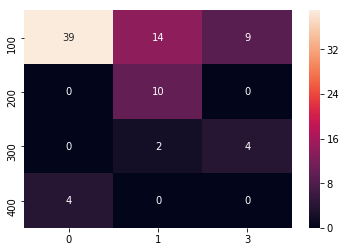

In [83]:
cmdf2 = pd.DataFrame(data=cm2, copy=True, index=allLabels, columns=allLabels2).loc[KLabels, AggloLabels]
cmdf2 = cmdf2.transpose()
sns.heatmap(cmdf2, annot=True)

### Entropy

#### Kmeans vs DBscan

In [84]:
proba = 0.1*cmdf1.values/cmdf1.values.sum(axis=1, keepdims=True) # divide each element of a row by the sum of the row
print(proba)
entropy = [stats.entropy(row, base=2) for row in proba]
print "entropy of each cluster:", entropy

[[0.00487805 0.06341463 0.03170732]
 [0.1        0.         0.        ]
 [       nan        nan        nan]
 [       nan        nan        nan]]
entropy of each cluster: [1.1546947117521666, 0.0, -inf, -inf]


/usr/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in divide
  """Entry point for launching an IPython kernel.


#### Kmeans vs Agglomerative clusterring

In [85]:
proba = 0.1*cmdf2.values/cmdf2.values.sum(axis=1, keepdims=True) # divide each element of a row by the sum of the row
print(proba)
entropy = [stats.entropy(row, base=2) for row in proba]
print "entropy of each cluster:", entropy

[[0.06290323 0.02258065 0.01451613]
 [0.         0.1        0.        ]
 [0.         0.03333333 0.06666667]
 [0.1        0.         0.        ]]
entropy of each cluster: [1.3096321094608279, 0.0, 0.9182958340544894, 0.0]


# Classification

## Construct the labels

In [95]:
from math import floors
sort_datatri=Z_datatri.sort_values('Life expectancy') # sort the normalized data
n=len(sort_datatri)

We decided to construct three classes :
    - class 1 : low life expectancy
    - class 2 : medium life expectancy
    - class 3 : high life expectancy

In [96]:
x=np.array([1,2,3]) # array needed to create the classes array
classes=np.repeat(x, floor(n/3))
classes

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [97]:
sort_datatri=sort_datatri.assign(classe=classes) # assigned each coutry to a class
sort_datatri=sort_datatri.drop(labels='Life expectancy', axis=1)
sort_datatri.head()

,Surface,Population,GNI,Gvnt_health_exp,Food Deficit,Nat_resources_rents,CO2 emissions,Mortality_diseases,under_five_deaths,Water_use,Suicide_rate,measles_immunization,classe
Country Code,,,,,,,,,,,,,
CAF,0.173244,-0.516499,-0.484739,-0.896960,1.890275,-0.216027,-0.538246,0.664492,2.322118,-1.386408,0.245358,-2.414426,1
SLE,-0.678952,-0.465482,-0.481514,-0.504129,1.456573,-0.071594,-0.529242,1.992194,2.752904,-1.506809,0.194744,-0.246995,1
TCD,1.196196,-0.327710,-0.440886,-1.126899,2.540828,1.105086,-0.540935,0.587524,3.003387,-2.061531,0.110387,-2.937599,1
CIV,-0.291821,-0.111628,-0.368721,-1.002936,-0.049336,-0.392889,-0.490374,1.376449,1.411942,-0.339187,0.785241,-1.143863,1
LSO,-0.743856,-0.577612,-0.479314,-0.526034,-0.362566,-0.621074,-0.358977,1.068576,0.671570,-0.488584,2.033722,0.201439,1


## KNN Classification

In [98]:
from sklearn.model_selection import train_test_split
from sklearn import neighbors
data_train, data_test, label_train, label_test = train_test_split(sort_datatri, classes, test_size=0.33, random_state=10)
sortedLabelList = sorted(list(set(classes)))

In [101]:
# knn model
model = neighbors.KNeighborsClassifier(n_neighbors=5, weights='uniform', p=2)

In [102]:
# Training
model.fit(data_train, label_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [109]:
# Testing
label_predict = model.predict(data_test)
print('accuracy = ', metrics.accuracy_score(label_test, label_predict))
print(metrics.classification_report(label_test, label_predict))

('accuracy = ', 0.6857142857142857)
             precision    recall  f1-score   support

          1       0.62      1.00      0.76         8
          2       0.64      0.50      0.56        14
          3       0.82      0.69      0.75        13

avg / total       0.70      0.69      0.68        35



In [110]:
metrics.confusion_matrix(y_true=label_test, y_pred=label_predict, labels=sortedLabelList)

array([[8, 0, 0],
       [5, 7, 2],
       [0, 4, 9]])

In [111]:
# Confusion matrix
import pandas as pds
pds.DataFrame(
    metrics.confusion_matrix(y_true=label_test, y_pred=label_predict, labels=sortedLabelList),
    columns=['Predicted ' + str(className) for className in sortedLabelList],
    index=['True ' + str(className) for className in sortedLabelList]
)

,Predicted 1,Predicted 2,Predicted 3
True 1,8,0,0
True 2,5,7,2
True 3,0,4,9


### Cross-validation

In [106]:
from sklearn.model_selection import cross_validate
cross_validate(model, sort_datatri, classes)

/usr/lib64/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([0.00107598, 0.00099492, 0.00107598]),
 'score_time': array([0.00085497, 0.00059319, 0.00078201]),
 'test_score': array([0.69444444, 0.77777778, 0.75757576]),
 'train_score': array([0.91304348, 0.92753623, 0.95833333])}

## Decision Tree